<a href="https://colab.research.google.com/github/afeld/python-public-policy/blob/master/hw_3_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NYU Wagner - Python Coding for Public Policy**
# Solutions to HW3: Analyzing and visualizing specific categories of 311 complaints

## Start by importing necessary packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from google.colab import drive

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Read and save our cleaned 311 Service Requests dataset as a pandas dataframe named "df"

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Data for Python/cleaned_311_data.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,18,21,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **Problem Statement:** 
There seems to be a general trend that the higher the community district population, the higher the number of 311 requests. However, there is a lot of variance in the data. What if we only look at complaint types that are likely influenced by population?

"Noise - Residential" and "HEAT/HOT WATER" were the most frequest requests in the entire 311 dataset. Let's try isolating the count of requests in each of those two categories versus all the other complaints.

##**Step 1**. 
First you will need to prep your data to get the count of complaints categorized as Noise - Residential, HEAT/HOT WATER, and everything else. You can update the code from lecture that gets the total count of 311 requests per CD to instead get the count of 311 requests per CD that meet the criteria for the 3 categories. You should create three seprate dataframes, one per category:

1. `complaint_type = 'Noise - Residential'`
2. `complaint_type = 'HEAT/HOT WATER'`
3. Everything else: `(complaint_type != 'Noise - Residential') & (complaint_type != 'HEAT/HOT WATER')`

First create 3 dataframes, that contain our desired rows based on the complaint_type row filtering.

In [ ]:
count_noise = df[df.complaint_type == 'Noise - Residential'].groupby('community_board').size().reset_index(name='count_of_311_requests')
print(len(count_noise))

count_heatwater = df[df.complaint_type == 'HEAT/HOT WATER'].groupby('community_board').size().reset_index(name='count_of_311_requests')
print(len(count_heatwater))

count_other = df[(df.complaint_type != 'HEAT/HOT WATER') & (df.complaint_type != 'Noise - Residential')].groupby('community_board').size().reset_index(name='count_of_311_requests')
print(len(count_other))

# note: we won't use this in the charts, but we can use it as a check that the subsets all add up to the correct total
count_all = df.groupby('community_board').size().reset_index(name='count_of_311_requests')
print(len(count_all))

69
66
77
77


Note the lengths of these dataframes. We can see that we're going to run into problems, because they're each a different length (i.e. have a different number of rows) and they're all greater than 59. There are only 59 community districts in the city, so these dataframes are including some extra invalid community district rows. The invalid rows include community board values containing "Unspecified" or district numbers that are higher than what exist in real life. Ex: '84 QUEENS', 'Unspecified BRONX'


Here's a list of all the valid borocd values that exist in the city:

In [ ]:
valid_borocds = ['101','102','103','104','105','106','107','108','109','110','111','112','201','202','203','204','205','206','207','208','209','210','211','212','301','302','303','304','305','306','307','308','309','310','311','312','313','314','315','316','317','318','401','402','403','404','405','406','407','408','409','410','411','412','413','414','501','502','503']

If we recode the community_board column into borocd, we can filter our dataframes to only keep valid borocd rows

In [ ]:
# this function will recode the community_board value into borocd in a new column

def recode_borocd_counts(row):
  if row.community_board[0] != 'U':
    if 'MANHATTAN' in row.community_board:
      return '1' + row.community_board[0:2]
    elif 'BRONX' in row.community_board:
      return '2' + row.community_board[0:2]
    elif 'BROOKLYN' in row.community_board:
      return '3' + row.community_board[0:2]
    elif 'QUEENS' in row.community_board:
      return '4' + row.community_board[0:2]
    elif 'STATEN ISLAND' in row.community_board:
      return '5' + row.community_board[0:2]
  else:
    return 'Invalid borocd'

# we can apply the function to each of our dataframes. this is the beauty of functions; you can reuse them on multiple objects!

count_noise['borocd'] = count_noise.apply(recode_borocd_counts, axis=1)

count_heatwater['borocd'] = count_heatwater.apply(recode_borocd_counts, axis=1)

count_other['borocd'] = count_other.apply(recode_borocd_counts, axis=1)

count_all['borocd'] = count_all.apply(recode_borocd_counts, axis=1)

Now we can filter the dataframes to only keep the valid borocd rows. Remember the `.isin()` function from one of our prior lectures?

In [ ]:
count_noise = count_noise[count_noise.borocd.isin(valid_borocds)]
print(len(count_noise))

count_heatwater = count_heatwater[count_heatwater.borocd.isin(valid_borocds)]
print(len(count_heatwater))

count_other = count_other[count_other.borocd.isin(valid_borocds)]
print(len(count_other))

count_all = count_all[count_all.borocd.isin(valid_borocds)]
print(len(count_all))

59
59
59
59


Great, now we have clean dataframes that are all the same, correct length. Let's make sure they add up.

In [ ]:
print(count_noise.head())
print(count_heatwater.head())
print(count_other.head())
print(count_all.head())

    community_board  count_of_311_requests borocd
1          01 BRONX                   3691    201
2       01 BROOKLYN                   5844    301
3      01 MANHATTAN                    722    101
4         01 QUEENS                   4589    401
5  01 STATEN ISLAND                   5052    501
    community_board  count_of_311_requests borocd
0          01 BRONX                   3346    201
1       01 BROOKLYN                   2868    301
2      01 MANHATTAN                    276    101
3         01 QUEENS                   2466    401
4  01 STATEN ISLAND                   1644    501
    community_board  count_of_311_requests borocd
1          01 BRONX                  20316    201
2       01 BROOKLYN                  59389    301
3      01 MANHATTAN                  20261    101
4         01 QUEENS                  53370    401
5  01 STATEN ISLAND                  58449    501
    community_board  count_of_311_requests borocd
1          01 BRONX                  27353    201


In [ ]:
27353 == 20316 + 3346 + 3691

True

## **Step 2**. 
Create a stacked bar chart comprised of three stacked bars. The total height of each bar (the sum of the three stacked bars) should reflect the total count of 311 complaints per CD.
- number of `'Noise - Residential'` complaints per CD
- number of `'HEAT/HOT WATER'` complaints per CD
- number of other complaints per CD 

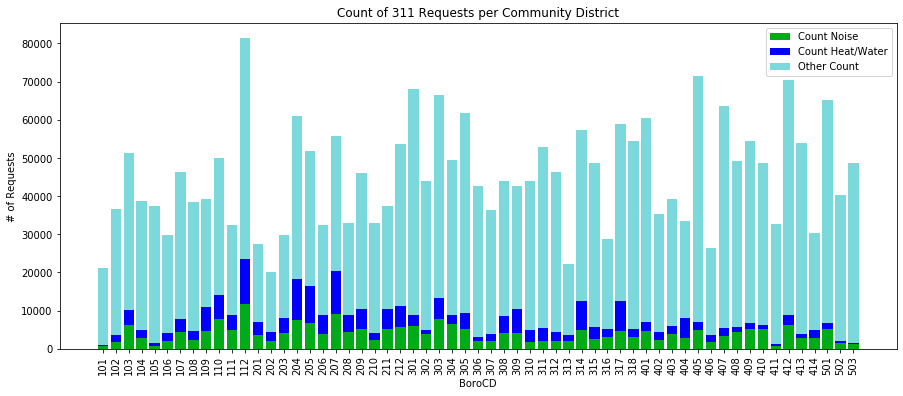

In [ ]:
# list of bar positions on x axis
position_on_x = np.arange(len(count_other))

# other - note: sorting by borocd so that bars from the same borocd will get stacked together
array_counts_other = np.array(count_other.sort_values('borocd').count_of_311_requests)
# noise
array_counts_noise = np.array(count_noise.sort_values('borocd').count_of_311_requests)
# heat
array_counts_heatwater = np.array(count_heatwater.sort_values('borocd').count_of_311_requests)

plt.figure(figsize=(15, 6))

plt.bar(
  position_on_x,
  array_counts_noise,
  align='center',
  color='#00ab1a',
  label='Count Noise')

plt.bar(
  position_on_x,
  array_counts_heatwater,
  bottom=array_counts_noise, 
  align='center',
  color='blue',
  label='Count Heat/Water')

plt.bar(
  position_on_x,
  array_counts_other,
  bottom=array_counts_heatwater+array_counts_noise, 
  align='center',
  color='#7bd8db',
  label='Other Count')

# the sorting of the x ticks must match the sorting of the bars 
plt.xticks(position_on_x, count_other.sort_values('borocd').borocd, rotation=90)

plt.title('Count of 311 Requests per Community District')
plt.xlabel('BoroCD')
plt.ylabel('# of Requests')
plt.legend()

## Optional sorting for Step 2.
If you wanted to sort the bars so they're ordered by a certain count subset or total counts, you need to do more data munging first to ensure that you only stacks bars together if they belong to the same borocd. The steps for doing that are outlined below.

In [ ]:
# start by creating a new dataframe that contains the count subsets joined together with the total counts.
# we want the count values for a given community district to all be joined together in single a row

counts = pd.merge(left=count_all, right=count_noise, left_on='borocd', right_on='borocd')

counts = pd.merge(left=counts, right=count_heatwater, left_on='borocd', right_on='borocd')

counts = pd.merge(left=counts, right=count_other, left_on='borocd', right_on='borocd')

counts.head()

,community_board_x,count_of_311_requests_x,borocd,community_board_y,count_of_311_requests_y,community_board_x,count_of_311_requests_x,community_board_y,count_of_311_requests_y
0,01 BRONX,27353,201,01 BRONX,3691,01 BRONX,3346,01 BRONX,20316
1,01 BROOKLYN,68101,301,01 BROOKLYN,5844,01 BROOKLYN,2868,01 BROOKLYN,59389
2,01 MANHATTAN,21259,101,01 MANHATTAN,722,01 MANHATTAN,276,01 MANHATTAN,20261
3,01 QUEENS,60425,401,01 QUEENS,4589,01 QUEENS,2466,01 QUEENS,53370
4,01 STATEN ISLAND,65145,501,01 STATEN ISLAND,5052,01 STATEN ISLAND,1644,01 STATEN ISLAND,58449


In [ ]:
# rename columns so we can tell which is which

counts.columns = ['community_board_x', 'count_all', 'borocd',
       'community_board_y', 'count_noise', 'community_board_x',
       'count_heatwater', 'community_board_y',
       'count_other']

counts.head()

,community_board_x,count_all,borocd,community_board_y,count_noise,community_board_x,count_heatwater,community_board_y,count_other
0,01 BRONX,27353,201,01 BRONX,3691,01 BRONX,3346,01 BRONX,20316
1,01 BROOKLYN,68101,301,01 BROOKLYN,5844,01 BROOKLYN,2868,01 BROOKLYN,59389
2,01 MANHATTAN,21259,101,01 MANHATTAN,722,01 MANHATTAN,276,01 MANHATTAN,20261
3,01 QUEENS,60425,401,01 QUEENS,4589,01 QUEENS,2466,01 QUEENS,53370
4,01 STATEN ISLAND,65145,501,01 STATEN ISLAND,5052,01 STATEN ISLAND,1644,01 STATEN ISLAND,58449


In [ ]:
# clean up dataframe to only keep columns we will use

counts = counts[['borocd', 'count_all', 'count_noise', 'count_heatwater', 'count_other']]

counts.head()

,borocd,count_all,count_noise,count_heatwater,count_other
0,201,27353,3691,3346,20316
1,301,68101,5844,2868,59389
2,101,21259,722,276,20261
3,401,60425,4589,2466,53370
4,501,65145,5052,1644,58449


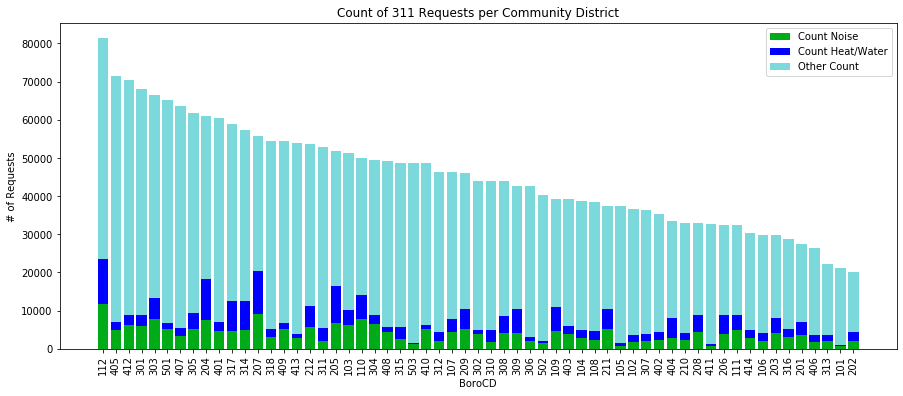

In [ ]:
# list of bar positions on x axis
position_on_x = np.arange(len(counts))

# other - note: sorting the entire dataframe by a column before selecting a specific column to use
array_counts_other = np.array(counts.sort_values('count_all', ascending=False).count_other)
# noise
array_counts_noise = np.array(counts.sort_values('count_all', ascending=False).count_noise)
# heat
array_counts_heatwater = np.array(counts.sort_values('count_all', ascending=False).count_heatwater)

plt.figure(figsize=(15, 6))

plt.bar(
  position_on_x,
  array_counts_noise,
  align='center',
  color='#00ab1a',
  label='Count Noise')

plt.bar(
  position_on_x,
  array_counts_heatwater,
  bottom=array_counts_noise, 
  align='center',
  color='blue',
  label='Count Heat/Water')

plt.bar(
  position_on_x,
  array_counts_other,
  bottom=array_counts_heatwater+array_counts_noise, 
  align='center',
  color='#7bd8db',
  label='Other Count')

# the sorting of the x ticks must match the sorting of the bars
plt.xticks(position_on_x, np.array(counts.sort_values('count_all', ascending=False).borocd), rotation=90)

plt.title('Count of 311 Requests per Community District')
plt.xlabel('BoroCD')
plt.ylabel('# of Requests')
plt.legend()

## **Step 3**. 
Create a scatter plot of community district's 311 counts per category (y-axis) vs. CD population (x-axis). The scatter plot should show each of the three complaint categories in a different color.

In [ ]:
population = pd.read_csv('https://data.cityofnewyork.us/api/views/xi7c-iiu2/rows.csv?accessType=DOWNLOAD')

def recode_borocd_pop(row):
  if row.Borough == 'Manhattan':
    return str(100 + row['CD Number'])
  elif row.Borough == 'Bronx':
    return str(200 + row['CD Number'])
  elif row.Borough == 'Brooklyn':
    return str(300 + row['CD Number'])
  elif row.Borough == 'Queens':
    return str(400 + row['CD Number'])
  elif row.Borough == 'Staten Island':
    return str(500 + row['CD Number'])
  else:
    return 'Invalid borocd'

population['borocd'] = population.apply(recode_borocd_pop, axis=1)

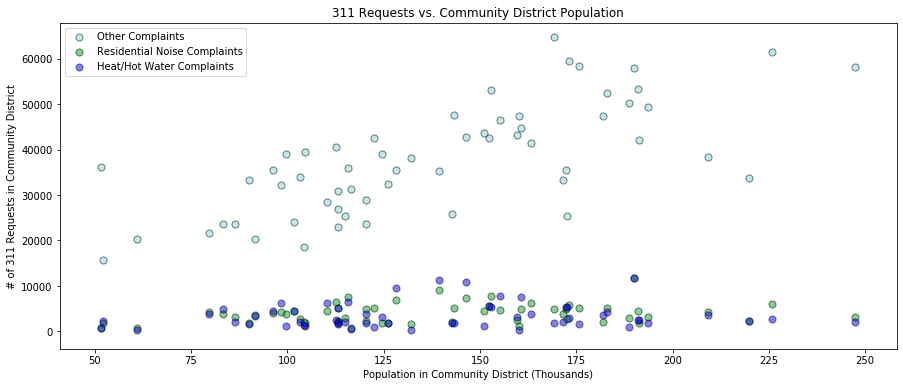

In [ ]:
# define the data that will be used
x = population.sort_values('borocd')['2010 Population']/1000

plt.figure(figsize=(15, 6))

plt.scatter(
  x, # x values
  merged_other.sort_values('borocd').count_of_311_requests, # y values
  s=50, # area of the circle marker
  c='#7bd8db', 
  edgecolors='black', 
  alpha=0.5, 
  label='Other Complaints') 

plt.scatter(
  x, 
  merged_noise.sort_values('borocd').count_of_311_requests, 
  s=50, 
  c='#00ab1a', 
  edgecolors='black', 
  alpha=0.5, 
  label='Residential Noise Complaints') 

plt.scatter(
  x, 
  merged_heatwater.sort_values('borocd').count_of_311_requests, 
  s=50, 
  c='blue', 
  edgecolors='black', 
  alpha=0.5, 
  label='Heat/Hot Water Complaints') 

plt.title('311 Requests vs. Community District Population')
plt.xlabel('Population in Community District (Thousands)')
plt.ylabel('# of 311 Requests in Community District')
plt.legend()
plt.show()

## **Examining results**
Does it seem like there's a positive correlation between population and noise complaints or population and heat/water complaints? What's a possible explanation for the relationship or lack of relationship?

If we zoom in to only look at noise and heat/water complaints, there doesn't seem to be strong relationship between population size and number of 311 requests.

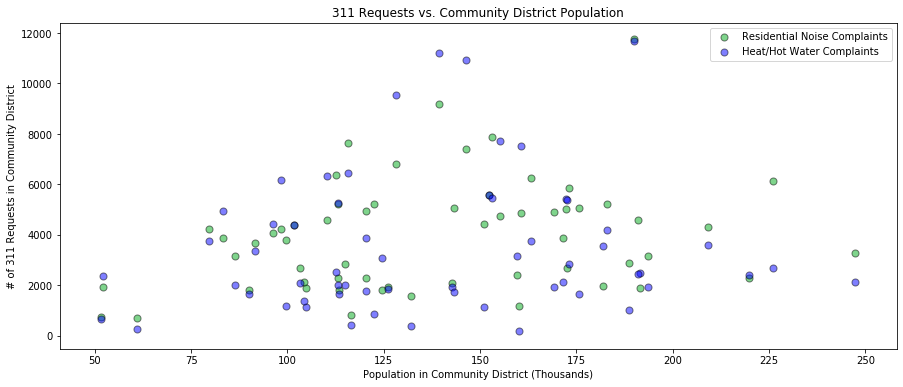

In [ ]:
#  the plot will automatically adjust the axes to fit the data included.
# if we exclude the "other" complaint data, we can see noise and heat/water more clearly.

plt.figure(figsize=(15, 6))

plt.scatter(
  x, 
  merged_noise.sort_values('borocd').count_of_311_requests, 
  s=50, 
  c='#00ab1a', 
  edgecolors='black', 
  alpha=0.5, 
  label='Residential Noise Complaints') 

plt.scatter(
  x, 
  merged_heatwater.sort_values('borocd').count_of_311_requests, 
  s=50, 
  c='blue', 
  edgecolors='black', 
  alpha=0.5, 
  label='Heat/Hot Water Complaints') 

plt.title('311 Requests vs. Community District Population')
plt.xlabel('Population in Community District (Thousands)')
plt.ylabel('# of 311 Requests in Community District')
plt.legend()
plt.show()

There are other factors that determine the frequency of these types of complaints in each community district. For heat and hot water complaints, other factors could be quality and cost of housing, age of building equipment, and responsiveness of landlords to tenants' needs. Residential noise complaints could be explained by age and demographic differences or by building construction quality (soundproofing).